In [27]:
import numpy as np
from brian2 import *
%matplotlib inline
import matplotlib.pyplot as plt
# from functions import *

# the following dictionary defines style parameters to resemble the style of the figures in the paper, however, uncommenting these 2 lines will not affect the results
my_params = {'figure.dpi' : 300, 'figure.figsize' : [3,2],'font.size':8,'font.family':'Arial','axes.spines.top': False, 'axes.spines.right': False} #adjust some of the default style parameters
plt.rcParams.update(my_params) # update the default style parameters with the style parameters defined above
#To revert to the default style parameters, uncomment the following line
# plt.rcParams.update(matplotlib.rcParamsDefault)

In [28]:
#-------------------------------------------------------------------------
# Helper functions
#-------------------------------------------------------------------------

#Defines a number of helper functions that is used to build the network or to analyse the data

def shuffled_idx(N_pre,N_post, conn_prob):
    '''
    Generates an array of pre and post-synaptic indices to connect neurons in a homogenous way, meaning that each neuron has the same number of incoming and outgoing connections 
    :param N_pre: The number of presynaptic neurons
    :param N_post: The number of postsynaptic neurons
    :param conn_prob: The connection probability (between 0 and 1) between pre and post synaptic neurons
    :return: an array with indices for both the pre and post population
    '''
    indices_pre=[]
    indices_post=[]
    for i in range (int(N_post*conn_prob+0.5)):
        indices_pre.append(np.arange(N_pre))
    for j in range (int(N_pre*conn_prob+0.5)):
        indices_post.append(np.arange(N_post))
    indices_pre = np.concatenate(indices_pre)
    indices_post = np.concatenate(indices_post)
    np.random.shuffle(indices_pre)
    np.random.shuffle(indices_post)
    if len(indices_pre) != len(indices_post):
        return print('Pre and postsynaptic indices have different lengths')
    elif all(indices_pre==indices_post):
        return print('ATTENTION, pre and post indices are the same, use a different seed to shuffle the indices')
    else:
        return indices_pre, indices_post
    
def raster_interval_idx(start_time, stop_time, spike_times, select='idx'):
    '''function: Truncated spiketrains for defined intervals
    :param start_time: float for the start of the interval in seconds
    :param stop_time: float for the end of the interval in seconds
    :param spike_times: list with the unitless spiketimes in seconds
    :select: either 'spikes' or 'idx', when spikes then it gives the spiketrain and when idx then it gives the start_idx and stop_idx
    :return: truncated spiketrain when 'spikes' and start or stop idx when 'idx'
    '''
        
    if len(spike_times)==0 or start_time > spike_times[-1] or stop_time < spike_times[0]:
        start_id='no_spikes'
        stop_id = 'no_spikes'        
    else:
        start_id = next(x[0] for x in enumerate(spike_times) if x[1] >= start_time)
        if stop_time > spike_times[-1]:
            stop_id=len(spike_times)
        else:
            stop_id = next(x[0] for x in enumerate(spike_times) if x[1] >= stop_time)
        
    if select == 'spikes':
        if start_id=='no_spikes':
            return []
        else:
            return spike_times[start_id:stop_id]
    if select == 'idx':
        return start_id, stop_id
    
def spike_times_unitless(spike_times):
    '''function: Function that removes the unit of seconds from
    :param spike_times: dictionary returned by brian2 with spiketimes in seconds
    :return: Dictionary with spike times without units'''
    
    spike_times_unitless = {}
    for k, v in spike_times.items():  # items method returns a list of tuple pairs
        spike_times_unitless[k] = v / second  # The for loop removes the seconds from the spiketrains
    return spike_times_unitless

In [3]:
#-------------------------------------------------------------------------
# Define the neuron models
#-------------------------------------------------------------------------

#Define neuron models to simulate different neuron populations with the Brian2 simulator. Unless otherwise stated, 
#the neuron models are identical to the ones defined in Naud et al. 2018 (Sparse bursts optimize information transmission in a multiplexed neural code,PNAS)

def pyramidal_model(N):
    '''
    Define a two-compartmental neuron model of L5 PCs.
    The neurons are modeled in the Brian2 simulater using two separate compartments (soma and dend) with coupled variables.
    Implementing two separate compartments allows monitoring somatic and burst activity online and simultaneously.
    :param N: Number of neurons in the network
    :return: The somatic and dendritic compartment of L5 PCs
    '''
    
    # Differential equations that define the dynamics of the somatic compartment of L5 PCs
    soma_eqs = '''
    du_s/dt = - (u_s - EL)/tau_s + (g_s * m  + I_s + w_s) / C_s: volt (unless refractory) # Somatic voltage equation
    dw_s/dt = - w_s / tau_w_s : amp # Somatic adapatation variable
    
    I_s = I_s_ext * pamp - g_gaba + g_ampa + I_s_bg: amp # The total somatic input current
    dI_s_bg/dt = (mu_s - I_s_bg) / tau_ou_s + sig_ou_s * pamp * xi_s/sqrt(tau_ou_s/2) : amp # Noisy background input equation defined by Ornstein-Uhlenbeck process 
    dg_ampa/dt = -g_ampa/tau_ampa : amp # The excitatory synaptic current
    dg_gaba/dt = -g_gaba/tau_gaba : amp # The inhibitory synaptic current
    
    #variables defined in the dendritic compartment but also used in the dendritic compartment
    
    start_trace_burst:1 (linked) 
    stop_trace_burst: 1 (linked) 
    u_d : volt (linked)
    m: 1 (linked)
    '''

    #equations that define the dynamics of the dendritic compartment
    # Note that start_trace_burst and stop_trace_burst don't define the neural model but allow for online detection of burst activity. Both variables decay exponentially but increase with 1 when a somatic spike is detected.
    #A burst is detected as soon as the start_trace_burst > 1.1. This occurs when a second somatic spike follows a first somatic spike within 16 ms. Start_trace_burst is reset to zero as soon as a burst is detected
    #and stays zero (in refractory mode) as long as the stop_burst_trace > 0.1. The stop_burst_trace will fall below 0.1 when there was more then 16 ms between spikes and this defines the end of a burst.
    #tau_burst is related to the burst criterium (in our case 16 ms) and is computed mathematically (see params dendrites).
    
    dend_eqs = '''
    du_d/dt = - (u_d - EL)/tau_d + (g_d * m + K + I_d + w_d) / C_d : volt # Dendritic voltage equation
    dw_d/dt = (- w_d + a_w_d * (u_d - EL)) / tau_w_d : amp #Dendritic adaptation variable
    
    I_d = I_d_ext * pamp  - g_gaba + g_ampa + I_d_bg : amp # The total dendritic input current
    
    dI_d_bg/dt = (mu_d - I_d_bg) / tau_ou_d + sig_ou_d * pamp * xi_d/sqrt(tau_ou_d/2)  : amp # Noisy background input equation defined by Ornstein-Uhlenbeck process 
    dg_ampa/dt = -g_ampa/tau_ampa : amp # The excitatory synaptic current
    dg_gaba/dt = -g_gaba/tau_gaba : amp # The inhibitory synaptic current
    

    dstart_trace_burst/dt=-start_trace_burst/tau_burst : 1 #Post-synaptic trace that helps to define the start of a burst
    dstop_trace_burst/dt=-stop_trace_burst/tau_burst : 1 #Post-synaptic trace that helps to define the end of a burst

    m = 1/(1 + exp(-(u_d - Ed) / Dm)) : 1 #Sigmoidal function defining the non-linearity in the dendritic compartment
    Ca_spike = 1/(1 + exp(-(u_d - Ed2) / Dm2)) : 1 #filtered voltage of the dendritic voltage to isolate the calcium spikes
    
    lastspike_soma : second (linked)
    K = (((t-lastspike_soma) > K1) * ((t-lastspike_soma)< K2)) * c_d : amp #Variable representing the back-propagating action potential. The injected current is a stepfunction with a value of 1 (* c_d) between 0.5 and 2.5 ms after a somatic spike and 0 otherwise.
    dburst_trace/dt =  -burst_trace/tau_stdp: 1 #Post-synaptic trace representing burst activity. This trace updates the inhibitory learning rule that controls burst activity 
    '''

    # Parameters somatic compartment
    params_soma = {
        'tau_s': 16.0 * msecond,
        'C_s': 370.0 * pfarad,
        'g_s': 1300.0 * pamp,
        'b_w_s': -200 * pamp,
        'tau_w_s': 100.0 * msecond,
        'EL': -0.07 * volt,

        'Ed': -0.038 * volt,
        'Dm': 0.006 * volt,
        'mu_s': 0 * pamp,
        'tau_ou_s': 2.0 * msecond,
        'tau_gaba': 10 * msecond,
        'tau_ampa': 5 * msecond,
                    }
    
    # Define the somatic compartment
    soma = NeuronGroup(N_PC, model=soma_eqs, threshold='u_s> -0.05 * volt',
                       reset='''
                             w_s += b_w_s
                             u_s = EL
                             start_trace_burst += 1
                             stop_trace_burst = 1''',
                       refractory= 3 * msecond, namespace=params_soma, method='euler', dt = 0.1 * msecond)

    soma.u_s = 'EL + rand() * 0.01 * volt'     #initialise the somatic voltage around the resting potential

    # Parameters dendritic compartment
    params_dend = {
        'tau_d': 7.0 * msecond,
        'C_d': 170.0 * pfarad,
        'g_d': 1200.0 * pamp,
        'c_d': 2600.0 * pamp,
        'tau_w_d': 30.0 * msecond,
        'a_w_d': -13 * nsiemens,
        'EL': -0.07 * volt,
        'Ed': -0.038 * volt,
        'Dm': 0.006 * volt,
        'Ed2': -0.02 * volt,
        'Dm2': 0.00001 * volt,
        'K1': 0.499 * msecond,
        'K2': 2.501 * msecond,
        'tau_burst' : - 16 / np.log(0.1) * msecond,  #0.1 comes from the criterium under which burst_stop_trace has to fall

        'mu_d': 0 * pamp,
        'tau_ou_d': 2.0 * msecond,
        'tau_gaba': 10 * msecond,
        'tau_ampa': 5 * msecond,
                    }

    # Define the dendritic compartment
    dend = NeuronGroup(N, model=dend_eqs, threshold='start_trace_burst > 1.1',
                       reset='''
                       burst_trace +=1
                       start_trace_burst = 0
                       ''',
                       refractory='stop_trace_burst>0.1', namespace=params_dend, method='euler', dt = 0.1 * msecond)

    # initialise dendritic voltage
    dend.u_d = 'EL + rand() * 0.01 * volt' #initialise the dendritic voltage around the resting potential

    #link dendritic and somatic variables
    soma.u_d = linked_var(dend.u_d)
    soma.m = linked_var(dend.m)
    dend.lastspike_soma = linked_var(soma.lastspike)
    soma.start_trace_burst = linked_var(dend.start_trace_burst)
    soma.stop_trace_burst = linked_var(dend.stop_trace_burst)
    return soma, dend

def SOM_interneurons(N):
    '''
    Neuron model of somatostatin positive interneurons (SOM) as defined in Naud et al. (2018).
    :param N: Number of SOM interneurons in the network
    :return: SOM interneuron population
    '''
    
    inh_eqs = '''
    du_i/dt = - (u_i - EL)/tau_SOM + (I_inh + w_i) / C_SOM: volt (unless refractory) # Voltage equation of SOMs
    dw_i/dt = - w_i / tau_w_SOM : amp # Adaptation variable of SOM interneurons

    I_inh = I_SOM_ext * pamp + g_ampa  - g_gaba + I_bg_SOM: amp # The total input current to the SOMs
    
    dI_bg_SOM/dt = (mu_SOM - I_bg_SOM) / tau_ou_SOM + sig_ou_SOM * pamp * xi/sqrt(tau_ou_SOM/2.) : amp #Noisy background input
    dg_ampa/dt = -g_ampa/tau_ampa : amp # The excitatory synaptic current
    dg_gaba/dt = -g_gaba/tau_gaba : amp # The inhibitory synaptic current
    '''

    params_SOM = {
        'EL': -0.07 * volt,
        'tau_SOM': 20 * msecond,
        'C_SOM': 100.0 * pfarad,
        'b_w_SOM': -150.0 * pamp,
        'tau_w_SOM': 100 * msecond,

        'mu_SOM': 0 * pamp,
        'tau_ou_SOM': 2.0 * msecond,
        'tau_gaba': 10 * msecond,
        'tau_ampa': 5 * msecond,
                    }

    # Define the inhibitory population
    inh = NeuronGroup(N, model=inh_eqs, threshold='u_i> -0.05 * volt',
                      reset='''
                            u_i = EL
                            w_i += b_w_SOM
                            ''',
                      refractory=3*msecond,
                      namespace=params_SOM, method='euler', dt = 0.1 * msecond)

    inh.u_i = 'EL + rand() * 0.01 * volt' #initialise the voltage around the resting potential

    return inh

#-------------------------------------------------------------------------
# Define the synapse models
#-------------------------------------------------------------------------

#Defining inhibitory plasticity models used in Fig 1, S1 and S2

def inh_plast_pre_post_burst(pre, post, conn_p, weight, eta):
    '''
    Function implementing inhibitory plasticity rule where the plasticity is dependent on the pre and post-synaptic activity (Fig 1).
    :param pre: name of the presynaptic population
    :param post: name of the postsynaptic population
    :param conn_p: connection probability between pre and post populations
    :param weight: initial weights of the pre post conneccction
    :param eta: learning rate
    :return: synapse object
    '''

    params = {
            'max_weight': 1000,
            'eta': eta
                       }


    pre_to_post = Synapses(pre, post,
                               '''
                               w : 1
                               dApre/dt = -Apre/tau_stdp : 1 (event-driven)
                               dApost/dt = -Apost/tau_stdp : 1 (event-driven)
                               ''',
                               on_pre='''
                                     Apre += 1.
                                     w = clip(w+eta*(Apost-target), 0, max_weight)
                                     g_gaba += w * pamp''',
                               on_post='''
                                     Apost += 1.
                                     w = clip(w+eta*Apre, 0, max_weight)
                                     ''', namespace=params, method='linear')

    pre_idx,post_idx = shuffled_idx(pre.N,post.N,conn_p) # Generates the indices of pre and post populations so that the connections are homogenous
    pre_to_post.connect(i=pre_idx, j=post_idx) #Connects the populations
    
    pre_to_post.w = weight # Initialisation of the connection weights

    return pre_to_post

def inh_plast_pre_post_ca(pre, post, conn_p, weight, eta):
    '''
    #Inhibitory plasticity model to control the burst rate using dendritic calcium spike (voltage rule) as signal for the post-synaptic activity (Fig S1)
    :param pre: name of the presynaptic population
    :param post: name of the postsynaptic population
    :param  target: target in a.u.
    :param conn_p: connection probability between pre and post populations
    :param weight: initial weights of the pre post conneccction
    :return: synapse object
    '''

    params = {
            'max_weight': 1000,
            'Ed2': -0.02 * volt,
            'Dm2': 0.00001 * volt,
            'eta': eta
                       }

    pre_to_post = Synapses(pre, post,
                               '''
                               w:1
                               dApre/dt=-Apre/tau_stdp : 1 (event-driven)
                               ''',
                               on_pre='''
                               Apre += 1.
                               w = clip(w+eta*(Ca_spike-target), 0, max_weight)
                               g_gaba += w * pamp''',
                               on_post = '''
                               w = clip(w+eta*Apre, 0, max_weight)
                               ''',
                               namespace=params, method='linear')

    pre_idx,post_idx = shuffled_idx(pre.N,post.N,conn_p)
    pre_to_post.connect(i=pre_idx, j=post_idx)

    pre_to_post.w = weight

    return pre_to_post

def inh_plast_post_burst(pre, post, conn_p, weight, eta):

    '''
    Inhibitory plasticity model to control the burst rate using bursts as signal for the post-synaptic activity but without presynaptic dependence (Fig S2)
    :param pre: name of the presynaptic population
    :param post: name of the postsynaptic population
    :param  target: target rate in Hz
    :param conn_p: connection probability between pre and post populations
    :param weight: initial weights of the pre post conneccction
    :return: synapse object
    '''

    params = {
            'max_weight': 1000,
            'eta': eta,
            'update_rate_dend': 50 *  msecond
                       }
    
    pre_to_post = Synapses(pre, post,
                               '''
                               w : 1
                               ''',
                               on_pre='''
                               g_gaba += w * pamp''',
                               namespace=params, method='linear')
    
    pre_to_post.run_regularly('w=clip(w+eta*(burst_trace-target),0.,max_weight)', dt = params['update_rate_dend'])

    pre_idx,post_idx = shuffled_idx(pre.N,post.N,conn_p)
    pre_to_post.connect(i=pre_idx, j=post_idx)
    
    pre_to_post.w = weight

    return pre_to_post

In [4]:
#Defining inhibitory plasticity models used in Fig 1, S1 and S2

#Inhibitory plasticity model to control the burst rate using bursts as signal for the post-synaptic activity (Fig 1)
def inh_plast_pre_post_burst(pre, post, conn_p, weight, eta):
    '''
    Function implementing inhibitory plasticity rule where the plasticity is dependent on the pre and post-synaptic activity.
    :param pre: name of the presynaptic population
    :param post: name of the postsynaptic population
    :param conn_p: connection probability between pre and post populations
    :param weight: initial weights of the pre post conneccction
    :param eta: learning rate
    :return: synapse object
    '''

    params = {
            'max_weight': 1000,
            'eta': eta
                       }


    pre_to_post = Synapses(pre, post,
                               '''
                               w : 1
                               dApre/dt = -Apre/tau_stdp : 1 (event-driven)
                               dApost/dt = -Apost/tau_stdp : 1 (event-driven)
                               ''',
                               on_pre='''
                                     Apre += 1.
                                     w = clip(w+eta*(Apost-target), 0, max_weight)
                                     g_gaba += w * pamp''',
                               on_post='''
                                     Apost += 1.
                                     w = clip(w+eta*Apre, 0, max_weight)
                                     ''', namespace=params, method='linear')

    pre_idx,post_idx = shuffled_idx(pre.N,post.N,conn_p) # Generates the indices of pre and post populations so that the connections are homogenous
    pre_to_post.connect(i=pre_idx, j=post_idx) #Connects the populations
    
    pre_to_post.w = weight # Initialisation of the connection weights

    return pre_to_post

#Inhibitory plasticity model to control the burst rate using dendritic calcium spike (voltage rule) as signal for the post-synaptic activity (Fig S1)
def inh_plast_post_burst(pre, post, conn_p, weight, eta):

    '''
    :param pre: name of the presynaptic population
    :param post: name of the postsynaptic population
    :param  target: target rate in Hz
    :param conn_p: connection probability between pre and post populations
    :param weight: initial weights of the pre post conneccction
    :return: synapse object
    '''

    params = {
            'max_weight': 1000,
            'eta': eta,
            'update_rate_dend': 50 *  msecond
                       }
    
    pre_to_post = Synapses(pre, post,
                               '''
                               w : 1
                               ''',
                               on_pre='''
                               g_gaba += w * pamp''',
                               namespace=params, method='linear')
    
    pre_to_post.run_regularly('w=clip(w+eta*(burst_trace-target),0.,max_weight)', dt = params['update_rate_dend'])

    pre_idx,post_idx = shuffled_idx(pre.N,post.N,conn_p)
    pre_to_post.connect(i=pre_idx, j=post_idx)
    
    pre_to_post.w = weight

    return pre_to_post

#Inhibitory plasticity model to control the burst rate using bursts as signal for the post-synaptic activity but without presynaptic dependence (Fig S2)
def inh_plast_pre_post_ca(pre, post, conn_p, weight, eta):

    '''
    :param pre: name of the presynaptic population
    :param post: name of the postsynaptic population
    :param  target: target in a.u.
    :param conn_p: connection probability between pre and post populations
    :param weight: initial weights of the pre post conneccction
    :return: synapse object
    '''

    params = {
            'max_weight': 1000,
            'Ed2': -0.02 * volt,
            'Dm2': 0.00001 * volt,
            'eta': eta
                       }

    pre_to_post = Synapses(pre, post,
                               '''
                               w:1
                               dApre/dt=-Apre/tau_stdp : 1 (event-driven)
                               ''',
                               on_pre='''
                               Apre += 1.
                               w = clip(w+eta*(Ca_spike-target), 0, max_weight)
                               g_gaba += w * pamp''',
                               on_post = '''
                               w = clip(w+eta*Apre, 0, max_weight)
                               ''',
                               namespace=params, method='linear')

    pre_idx,post_idx = shuffled_idx(pre.N,post.N,conn_p)
    pre_to_post.connect(i=pre_idx, j=post_idx)

    pre_to_post.w = weight

    return pre_to_post

### In a first step we illustrate how to model L5 Pyramidal cells and plot the dendritic voltage

Starting simulation at t=0. s for a duration of 5. s
5.0 (100%) simulated in 3s


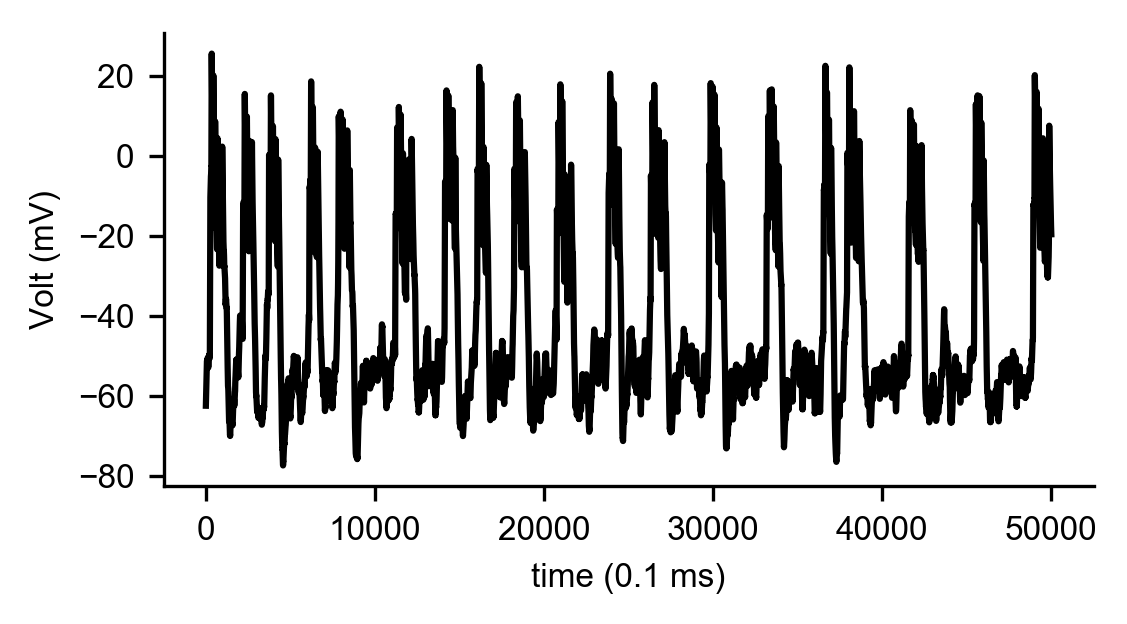

In [16]:
#-------------------------------------------------------------------------
# Run the simulation
#-------------------------------------------------------------------------

start_scope()#brian2 function, all objects created before this call will no longer be automatically included by the magic functions such as run()
tau_stdp = 20 *msecond
N_PC = 2 #Number of L5 PC cells
I_s_ext = 400 #External somatic input current in pA 
I_d_ext = 500 #External dendritic input curren in pA
sig_ou_s =  100 #Noise on the external somatic input current in pA
sig_ou_d = 200 #Noise on the external dendritic input current in pA
simulation_time = 5 #in seconds

soma,dend= pyramidal_model(N_PC) #Function that defines the L5 pyramidal model 
var_dend=StateMonitor(dend,('u_d'), record = [0]) #Records the statevariable 'dendritic voltage u_d' during a run
run(simulation_time*second,report='stdout',profile=True) #run the simulation

#-------------------------------------------------------------------------
# Plot the figure
#-------------------------------------------------------------------------

fig = plt.figure(figsize = (4,2))
plt.plot(var_dend.u_d[0]*1000, color ='k') # plot the dendritic voltage for the duration of the simulation
plt.ylabel('Volt (mV)')
plt.xlabel('time (0.1 ms)')
plt.show()

### In a second step a population of L5 cells was simulated for different dendritic input and noise levels. This illustrates how external noise influences the input-output function of the burst response.

- Simulation of L5 PCs with 0.0 pA of external noise
I dend ext = -100000000000000.0
I dend ext = 100000000000000.0
I dend ext = 300000000000000.0
- Simulation of L5 PCs with 200000000000000.0 pA of external noise
I dend ext = -100000000000000.0
I dend ext = 100000000000000.0
I dend ext = 300000000000000.0


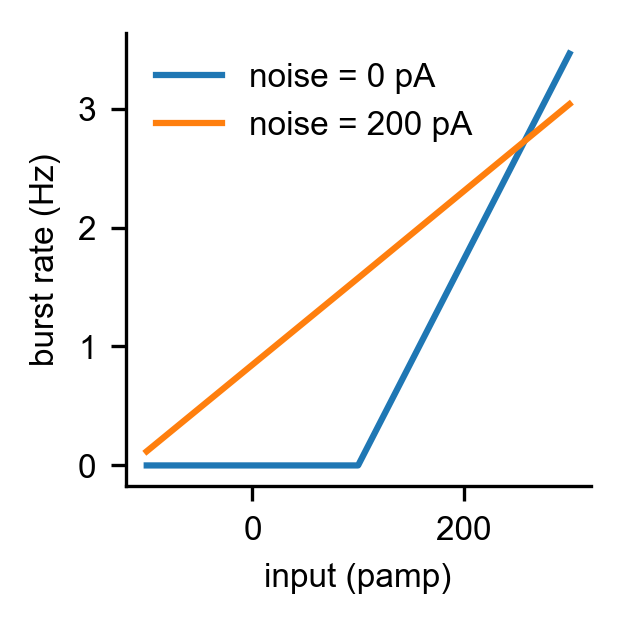

In [15]:
#-------------------------------------------------------------------------
# Run the simulation
#-------------------------------------------------------------------------

start_scope() # #brian2 function, all objects created before this call will no longer be automatically included by the magic functions such as run()
N_PC = 1600 # Number of L5 PC cells
I_s_ext = 500  # External somatic input current in pA
I_d_ext_val = np.arange(-100,400,200)  # Range of external dendritic inputs current in pA, in the paper we used smaller intervals for the dendritic values but to reduce the compute we took steps of 200 pA
I_d_ext = I_d_ext_val[0] #First dendritic input value, Brian2 needs to have an explicit variable I_d_ext when building the L5 PC model
sig_ou_s =  100 # Noise level of the external somatic input current in pA
sig_ou_d_val = np.array([0,200])# Noise levels of different external dendritic input currents in pA
sig_ou_d =  sig_ou_d_val[0] #First dendritic input value, Brian2 needs to have an explicit variable sig_ou_d when building the L5 PC model
simulation_time = 2 #in seconds, should be bigger then 1 second so that the system can settle in the 1st second and then we can compute the burst rate from the 2nd second

soma,dend=pyramidal_model(N_PC) #Function that defines the L5 pyramidal model 
dend_rate = PopulationRateMonitor(dend) # brian2 monitor recording time-varying firing rate of a population of neurons

burst_rate = np.zeros((len(sig_ou_d_val),len(I_d_ext_val)))
store() #Store the state of the network and all included objects.
for i in range (len(sig_ou_d_val)): #The simulation is run multiple times for different noise levels
    print('- Simulation of L5 PCs with {} pA of external noise'.format(sig_ou_d_val[i]/pamp))
    for j in range (len(I_d_ext_val)):
        restore() #To restore the state of the network and all included objects. This is important when running multiple simulations
        print('I dend ext = {}'.format(I_d_ext_val[j]/pamp))
        I_d_ext = I_d_ext_val[j] #define the dendritic input level
        sig_ou_d = sig_ou_d_val[i] #define the dendritic noise level
        run(simulation_time*second,profile=True) #run the simulation
        burst_rate[i,j] = np.mean(dend_rate.rate[-1000:]/Hz) #take the mean burst rate across all L5 PCs of the last second
        
#-------------------------------------------------------------------------
# Plot the figure
#-------------------------------------------------------------------------

plt.figure(figsize = (2,2))
plt.plot(I_d_ext_val,burst_rate[0,:], label = ('noise = {} pA'.format(sig_ou_d_val[0])))
plt.plot(I_d_ext_val,burst_rate[1,:], label = ('noise = {} pA'.format(sig_ou_d_val[1])))
plt.xlabel('input (pamp)')
plt.ylabel('burst rate (Hz)')
plt.legend(frameon=False)
plt.show()

### In the following section we explore how inhibitory plasticity controls the burst rate.
In the paper we explored the behaviour of 3 different inhibitory plasticity rules to control the burst rate of L5 PCs (in respectively Fig 1, FigS1 and FigS2)
- For Fig 1 the inhibitory plasticity rule is spike-time dependent and conditioned on pre- and postsynaptic activity levels, where post-synaptic activity is defined by burst activity
- For Fig S1 we used a voltage dependent variant of the plasticity rule where post-synaptic activity is defined by dendritic calcium spikes. This rule is also spike-time dependent
- Fig Fig S2 the plasticity is only dependent on post-synaptic activity which is defined by burst activity



In [24]:
#-------------------------------------------------------------------------
# Run the simulation
#-------------------------------------------------------------------------

start_scope() #brian2 function, all objects created before this call will no longer be automatically included by the magic functions such as run()
simulation_time = 50

# With the variable plast_rule we define the inhibitory plasticity rule to control the burst rate of PCs.
plast_rule = 'pre_post_burst' # Fig 1
# plast_rule ='pre_post_ca' # Fig S1
# plast_rule = 'post_burst' # Fig S2

#Create the PC population
N_PC = 1600 #Number of L5 PC cells
I_s_ext = 500 #External somatic input current in pA 
I_d_ext_val = [250, 650] #Low and high external dendritic input current in pA
I_d_ext = I_d_ext_val[0] # Low dendritic input current, Brian2 needs to have an explicit variable I_d_ext when building the L5 PC model
sig_ou_s = 100 #Noise on the external somatic input current in pA
sig_ou_d = 100 #Noise on the external dendritic input current in pA
soma,dend= pyramidal_model(N_PC)  #Function that defines the L5 pyramidal model 
dend_spikemonitor = SpikeMonitor(dend) # brian2 monitor recording spikes from a Neuron group
dend_rate = PopulationRateMonitor(dend) # brian2 monitor recording time-varying firing rate of a population of neurons

#Create the SOM population
I_SOM_ext = 90 #External input current to the SOM population in pA 
sig_ou_SOM = 400 #Noise on the external input current of SOM population in pA
N_SOM = 400 # Number of SOM neurons

SOM = SOM_interneurons(N_SOM) #Function that defines the SOM neuronal model

#Connect SOMs with dendritic compartment of PCs
#The learning rate eta was increased to reduce the simulation time without qualitative change of results
tau_stdp = 20 * msecond #time constant of synaptic trace of post synaptic activity
if plast_rule == 'pre_post_burst':
    burst_target = 1 * Hz # target burst rate rho_0
    target = 2 * burst_target * tau_stdp  #Similar to the inhibitory rule described in Vogels et al. 2011, the target burst rate relates mathematically with the target (target = 2 * target burst rate * tau_stdp)
    SOM_dend = inh_plast_pre_post_burst(SOM, dend, conn_p = 1, weight = 10, eta = 0.5) #eta in paper = 0.1
elif plast_rule == 'pre_post_ca':
    target = 0.05 #a.u. The target value that corresponds with a burst rate of 1 Hz was determined empirically
    SOM_dend = inh_plast_pre_post_ca(SOM, dend, conn_p = 1, weight = 10, eta = 0.5) #eta in paper = 0.1
elif plast_rule == 'post_burst':
    burst_target = 1*Hz
    target = burst_target * tau_stdp # The target value relates to the target rate (target  = burst_target * tau_stdp)
    SOM_dend = inh_plast_post_burst(SOM, dend, conn_p = 1, weight = 10, eta = 0.5) #eta in paper = 0.1

var_SOM_dend=StateMonitor(SOM_dend, ('w'),record=np.arange(25),dt=100*msecond) # brian2 monitor recording state variables of the synapse object, in this case the first 25 connections each 100 ms.

#Run the simulations multiple times for strong and weak input currents and store the data for plotting
store() #Store the state of the network and all included objects.
burst_rate = {}
w_SOM_dend = {}
burst_times = {}
for j in range (len(I_d_ext_val)):
    print('-> {} pA of external dend input'.format(I_d_ext_val[j]/pamp))
    restore() #Restore the state of the network and all included objects.
    I_d_ext = I_d_ext_val[j] #define dendritic input level
    run((simulation_time)*second,report='stdout',profile=True) #run the simulation
    #store the data after running the simulation
    burst_rate[j] = dend_rate.smooth_rate(window='flat', width = 1000 * ms)/Hz #store the burst rate
    w_SOM_dend[j] = var_SOM_dend.w #store the weights
    burst_times[j] = dend_spikemonitor.spike_trains() #store the burst times

-> 250000000000000.0 pA of external dend input
Starting simulation at t=0. s for a duration of 50. s
2.4034 (4%) simulated in 10s, estimated 3m 18s remaining.
4.843100000000001 (9%) simulated in 20s, estimated 3m 6s remaining.
7.2854 (14%) simulated in 30s, estimated 2m 56s remaining.
9.7462 (19%) simulated in 40s, estimated 2m 45s remaining.
12.2093 (24%) simulated in 50s, estimated 2m 35s remaining.
14.663400000000001 (29%) simulated in 1m 0s, estimated 2m 25s remaining.
17.1223 (34%) simulated in 1m 10s, estimated 2m 14s remaining.
19.561500000000002 (39%) simulated in 1m 20s, estimated 2m 4s remaining.
21.9995 (43%) simulated in 1m 30s, estimated 1m 55s remaining.
24.4415 (48%) simulated in 1m 40s, estimated 1m 45s remaining.
26.886200000000006 (53%) simulated in 1m 50s, estimated 1m 35s remaining.
29.3267 (58%) simulated in 2m 0s, estimated 1m 25s remaining.
31.7664 (63%) simulated in 2m 10s, estimated 1m 15s remaining.
34.202400000000004 (68%) simulated in 2m 20s, estimated 1m 5s

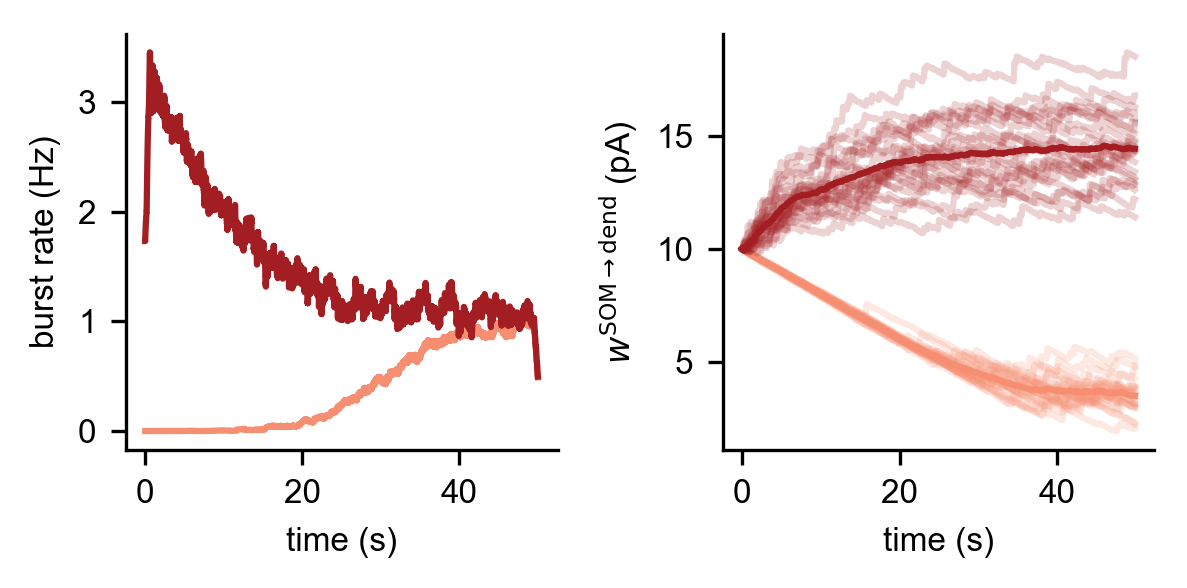

In [25]:
#---------------------------------------------------------------------------------------------
# Plot the burst and weight dynamics during learning
#---------------------------------------------------------------------------------------------

colors = ['#F68E71','#A31E22']

#Figure plotting the burst rate and weights for low and high dendritic input levels.
#Note that the burst rate for the first and last time points is lower, this is an artefact caused by the smoothening function of brian2.
plt.figure(figsize = (4,2))

plt.subplot(121)
for j in range (len(I_d_ext_val)):
    time = np.arange(0, len(burst_rate[j])/10000,0.0001) #sampling rate of the burst rate is 0.1 ms so the step size of the numpy array is 0.0001 seconds
    plt.plot(time,burst_rate[j],colors[j])
plt.ylabel('burst rate (Hz)', fontname='Arial', fontsize=8)
plt.xlabel('time (s)', fontname='Arial', fontsize=8)

plt.subplot(122)
 #weights were sampled every 100 ms
for j in range (len(I_d_ext_val)):
    for i in range (25):
        time = np.arange(0, len(w_SOM_dend[j][i])/10, 0.1) #sampling rate of the weight values rate is 100 ms (to reduce memory needs) so the step size of the numpy array is 0.1 seconds
        plt.plot(time, w_SOM_dend[j][i],color = colors[j], alpha = 0.2) #plot individual weight traces
    average_weights = np.mean(w_SOM_dend[j], axis=0) # compute the mean weight
    plt.plot(time,average_weights,color = colors[j]) #plot the mean weight of the 25 traces
plt.ylabel(r'$w^{\mathrm{{SOM}}\rightarrow \mathrm{dend}}$ (pA)', fontname='Arial', fontsize=8)
plt.xlabel('time (s)', fontname='Arial', fontsize=8)
plt.tight_layout()
plt.show()

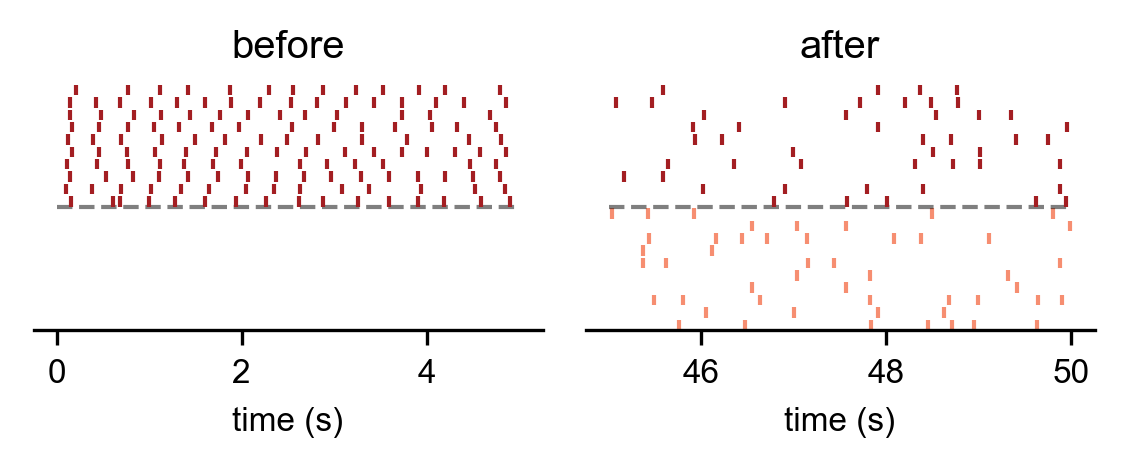

In [29]:
#---------------------------------------------------------------------------------------------
#Plot burst rasters before and after learning for low and high dendritic input levels
#---------------------------------------------------------------------------------------------
def raster_bursts(burst_times_dict, start_time, stop_time, colors, ax):
    '''
    Function plotting the raster plots of burst activity
    :param burst_times_dict: cictionary with the burst times for low and high dendritic input values
    :param start_time:  start time of plotting bursts
    :param stop_time: stop time of plotting bursts
    :param colors: colors for low and high dendritic input currents
    :param ax: plotting axis
    :return: synapse object
    '''
    
    y_pos = 0
    for j in range(len(burst_times_dict)):
        burst_times= spike_times_unitless(burst_times_dict[j])
        for i in range(10):
            start_idx, stop_idx = raster_interval_idx(start_time, stop_time, burst_times[i], 'idx') # retrieve the indices of the spikes
            if start_idx != 'no_spikes':
                plt.vlines(burst_times[i][start_idx:stop_idx], y_pos, y_pos + 0.85, color=colors[j], linewidth=1)
            y_pos += 1
            if y_pos == 10:
                plt.hlines(y_pos, start_time , stop_time, linestyle='--', color = 'k',alpha=0.5, linewidth=1)
    
    plt.ylim(0,20)
    plt.xlabel('time (s)')
    ax.spines['left'].set_visible(False) # remove the spines of the y-axis
    ax.get_yaxis().set_visible(False)   

fig_raster = plt.figure(figsize=(3.8, 1.6)) 
ax_1 = fig_raster.add_subplot(121)
ax_1.set_title('before')
raster_bursts(burst_times, 0, 5, colors, ax_1)
ax_2 = fig_raster.add_subplot(122)
ax_2.set_title('after')
raster_bursts(burst_times, simulation_time-5, simulation_time, colors, ax_2) 
plt.tight_layout()
plt.show()

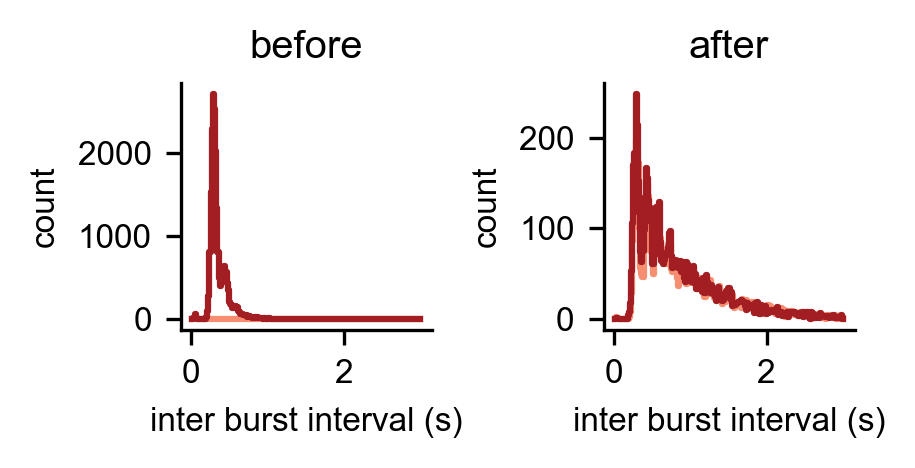

In [30]:
#---------------------------------------------------------------------------------------------
# Plot the interburst intervals before and after learning for low and high dendritic input levels
#---------------------------------------------------------------------------------------------
fig_IBI = plt.figure(figsize=(3, 1.6))
colors = ['#F68E71','#A31E22']
def histo_bursts(burst_times_dict, start, stop, colors, ax):
    for j in range(len(burst_times_dict)):
        burst_times= spike_times_unitless(burst_times_dict[j])
        ISI = []
        for i in range(len(burst_times)):
            burst_times_interval = raster_interval_idx(start, stop, burst_times[i], 'spikes')
            ISI.append(np.diff(burst_times_interval))
        ISI_all = [item for sublist in ISI for item in sublist] #concatenate all the lists with interburst values into a single list
        
        hist = np.histogram(ISI_all, 200, range=(0, 3),density=False)
        hist_values=hist[0]
        hist_low_boundary = hist[1][1:]
        plt.step(hist_low_boundary, hist_values, color=colors[j])
    
    plt.ylabel('count')
    plt.xlabel('inter burst interval (s)')

ax_1 = fig_IBI.add_subplot(121)
ax_1.set_title('before')
histo_bursts(burst_times, 1, 6, colors, ax_1)
ax_2 = fig_IBI.add_subplot(122)
ax_2.set_title('after')
histo_bursts(burst_times, 45, 50, colors, ax_2) 

plt.tight_layout()
plt.show()

### In a final step we demonstrate that the plasticity rule works for different target levels

- Target = 0.01
Starting simulation at t=0. s for a duration of 50. s
2.9129 (5%) simulated in 10s, estimated 2m 42s remaining.
5.8683000000000005 (11%) simulated in 20s, estimated 2m 30s remaining.
8.7573 (17%) simulated in 30s, estimated 2m 21s remaining.
11.7241 (23%) simulated in 40s, estimated 2m 11s remaining.
14.6403 (29%) simulated in 50s, estimated 2m 1s remaining.
17.5612 (35%) simulated in 1m 0s, estimated 1m 51s remaining.
20.474 (40%) simulated in 1m 10s, estimated 1m 41s remaining.
23.4582 (46%) simulated in 1m 20s, estimated 1m 31s remaining.
26.410099999999996 (52%) simulated in 1m 30s, estimated 1m 20s remaining.
29.282300000000006 (58%) simulated in 1m 40s, estimated 1m 11s remaining.
32.2172 (64%) simulated in 1m 50s, estimated 1m 1s remaining.
35.1017 (70%) simulated in 2m 0s, estimated 51s remaining.
38.0379 (76%) simulated in 2m 10s, estimated 41s remaining.
40.9268 (81%) simulated in 2m 20s, estimated 31s remaining.
43.8868 (87%) simulated in 2m 30s, estimated 21

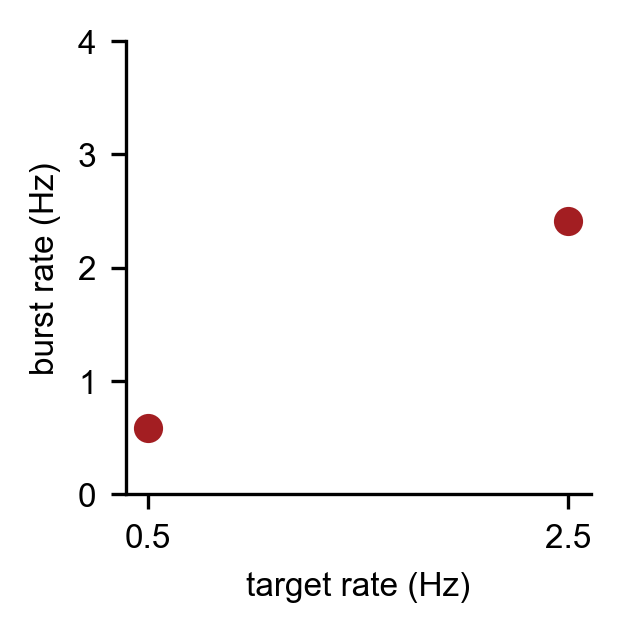

In [38]:
start_scope()
simulation_time = 50

# With the variable plast_rule we define the inhibitory plasticity rule to control the burst rate of PCs.
plast_rule = 'pre_post_burst' # Fig 1
# plast_rule ='pre_post_ca' # Fig S1
# plast_rule = 'post_burst' # Fig S2

#create L5 PCs
N_PC = 1600 #Number of L5 PC cells
I_s_ext = 500 #External somatic input current in pA 
I_d_ext = 650 #External dendritic input current in pA 
sig_ou_s= 100  #Noise on the externa somatic input current in pA
sig_ou_d= 100  #Noise on the externa dendritic input current in pA
soma,dend= pyramidal_model(N_PC) #Function that defines the L5 pyramidal model 
dend_rate = PopulationRateMonitor(dend) # brian2 monitor recording time-varying firing rate of a population of neurons

#create SOM population
N_SOM=400 
I_SOM_ext = 90 #External input current to the SOM population in pA 
sig_ou_SOM = 400 #Noise on the external input current of SOM population in pA
SOM = SOM_interneurons(N_SOM) #Function that defines the SOM population

#Connect SOMs with dendritic compartment of PCs
#The learning rate eta was increased to reduce the simulation time without qualitative change of resultstau_stdp = 20 * msecond
tau_stdp = 20 * msecond #time constant of synaptic trace of post synaptic activity
if plast_rule == 'pre_post_burst':
    target_val = [0.5, 2.5] * Hz * 2 * tau_stdp #Similar to the inhibitory rule described in Vogels et al. 2011, the target burst rate relates mathematically with the target (target = 2 * target burst rate * tau_stdp)
    target = target_val[0]
    SOM_dend = inh_plast_pre_post_burst(SOM, dend,conn_p = 1, weight = 10, eta = 0.5) 
    var_SOM_dend=StateMonitor(SOM_dend, ('w'),record=np.arange(25),dt=1*msecond)
elif plast_rule == 'pre_post_ca':
    target_val = [0.02,0.1] # The target values (a.u.) that corresponds with a burst rate of respectively 0.5 and 2 Hz
    SOM_dend = inh_plast_pre_post_ca(SOM, dend, conn_p = 1, weight = 10, eta = 0.5)
    var_SOM_dend=StateMonitor(SOM_dend, ('w'),record=np.arange(25),dt=1*msecond)
elif plast_rule == 'post_burst':
    target_val = [0.5,2.5] * Hz * tau_stdp # The target value relates to the target rate (target  = burst target rate * tau_stdp)
    target = target_val[0]
    SOM_dend = inh_plast_post_burst(SOM, dend, conn_p = 1, weight = 10, eta = 0.5)
    var_SOM_dend=StateMonitor(SOM_dend, ('w'),record=np.arange(25),dt=1*msecond)

burst_rate = []
store() #Store the state of the network and all included objects.
for i in range (len(target_val)):
    print('- Target = {}'.format(target_val[i]))
    restore() #To restore the state of the network and all included objects. This is important when running multiple simulations
    target = target_val[i]
    run(simulation_time*second,report='stdout',profile=True) #run the simulation
    burst_rate.append(np.mean((dend_rate.rate/Hz)[-10000:])) #take the mean burst rate across all L5 PCs of the last second of the simulation
    
#---------------------------------------------------------------------------------------------
# Plot the burst rate for different target values
#---------------------------------------------------------------------------------------------

plt.figure(figsize = (2,2))
if plast_rule == 'pre_post_burst':
    target_values = target_val/(Hz * 2 * tau_stdp)
    x_label = 'target rate (Hz)'
elif plast_rule == 'pre_post_ca':
    target_values = target_val
    xlabel = 'target (a.u.)'
elif plast_rule == 'post_burst':
    target_values = target_val/(Hz * tau_stdp)
    x_label = 'target rate (Hz)'
    
plt.scatter(target_values,burst_rate, color = '#A31E22')
plt.ylabel('burst rate (Hz)')
plt.xlabel(x_label)
plt.xticks(target_values)
plt.ylim(0,4)
plt.show()